In [374]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Rescaling, MaxPooling2D, Activation, Input, concatenate
from tensorflow.keras.utils import to_categorical, get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from PIL import Image
import os
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import random

---

# **Data**

## Import

In [375]:
import pathlib

data_dir = pathlib.Path('data/')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


2


## DataFrame

In [376]:
data_dir = pathlib.Path('data/')
image_paths = list(data_dir.glob('*/*.jpg'))

data = []
for image_path in image_paths:
    label = image_path.parent.name
    data.append((str(image_path), label))

df = pd.DataFrame(data, columns=['image', 'label'])

## Resize

In [377]:
img_size = 128

def load_image(image_path):
    img = Image.open(image_path).convert('RGB') 
    img = img.resize((img_size, img_size))
    return np.array(img)

df['image'] = df['image'].apply(load_image)
df

,image,label
0,"[[[122, 137, 143], [156, 162, 159], [156, 163,...",Chène
1,"[[[74, 124, 175], [74, 124, 174], [74, 124, 17...",Caroubier


## One Hot Encoding

In [378]:
cat = ['Caroubier', 'Chène', 'Faux-poivrier', 'Frène', 'Pistachier', 'Tipa']
df['label'] = pd.Categorical(df['label'])
df['label'] = df['label'].cat.codes
df['label'] = to_categorical(df['label'])

## Shuffle

In [379]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

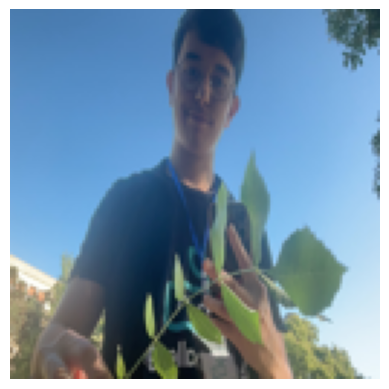

In [380]:
def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')  # Hide the axis
    plt.show()

# Example usage: Display the first image in the dataframe
display_image(df['image'].iloc[0])

---

# **Model**

- Time
- Pixels
- Layers
- Neurons
- Regularisation
- Learning Rate

In [381]:
def create_model(conv_layers, dense_layers, input_shape, num_classes, regularization):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Rescaling(1./255))  # Normalize the input images
    for filters, kernel_size in conv_layers:
        model.add(Conv2D(filters, kernel_size, kernel_regularizer=regularization))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    for units in dense_layers:
        model.add(Dense(units, activation='relu', kernel_regularizer=regularization))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularization))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

conv_layers = [(32, 3), (64, 3), (64, 3), (64, 3)]
dense_layers = [32]
input_shape = (img_size, img_size, 3)
num_classes = 6
regularization = l2(0.01)


In [382]:
model = create_model(conv_layers, dense_layers, input_shape, num_classes, regularization)
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_98 (Activation)      │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_99 (Activation)      │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_100 (Activation)     │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_101 (Activation)     │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,206 (653.15 KB)

 Trainable params: 167,206 (653.15 KB)

 Non-trainable params: 0 (0.00 B)

## Data Augmentation

In [383]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=10)
val_generator = val_datagen.flow(X_val, y_val, batch_size=10)

In [384]:
# learning_rate = 0.001
# optimizer = Adam(learning_rate=learning_rate)
# model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])


model.fit(train_generator, epochs=1, validation_data=val_generator)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_50" is incompatible with the layer: expected axis -1 of input shape to have value 2304, but received input with shape (None, 12544)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
  • training=True
  • mask=None